# Event-Tracking data synchronization

Kloppy supports the two main types of data commonly used in soccer analytics: [event data](examples/event_data) and [tracking data](/examples/tracking_data). Both are useful on their own, but only by combining them one can get a complete picture of the game. The problem is that these two types of data are often not synchronized, meaning that the time of an event doesn't match the position of players at that time in the tracking dataset. This notebook illustrates how Kloppy can be used to make these data sources match up.

In [1]:
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 20
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from kloppy.domain.services.synchronizers import utils
from kloppy.domain.services.synchronizers import viz
from kloppy.domain.services.synchronizers import config
from kloppy.domain.services.synchronizers import features

## Loading Metrica data

In [4]:
from kloppy import metrica

# Load the raw data, we'll only load the first 30 seconds of the game
API_URL = "https://raw.githubusercontent.com/metrica-sports/sample-data/master/data"
tracking_dataset = metrica.load_tracking_epts(
    meta_data=f"{API_URL}/Sample_Game_3/Sample_Game_3_metadata.xml",
    raw_data=f"{API_URL}/Sample_Game_3/Sample_Game_3_tracking.txt",
    limit=30*25,
    coordinates="metrica"
)
event_dataset = metrica.load_event(
    meta_data=f"{API_URL}/Sample_Game_3/Sample_Game_3_metadata.xml",
    event_data=f"{API_URL}/Sample_Game_3/Sample_Game_3_events.json",
    coordinates="metrica"
)

# Remove events that occur after the last tracking frame
event_dataset.records = [r for r in event_dataset if r.timestamp < 30]

## Time-based synchronization

If the event data and tracking data are already synchronized, it's easy: we can synchronize both datasources by matching the timestamps.

In [5]:
time_synced_event_dataset = event_dataset.sync(tracking_dataset, strategy="timestamps")

This will set the `freeze_frame` attribute of each event to the best matching tracking frame. We can plot the result as an amimation, or we can plot each event with it's corresponding freeze frame.

In [6]:
anim = viz.animate_alignment(
    time_synced_event_dataset, 
    tracking_dataset[500:]
)
#HTML(anim.to_jshtml())
HTML(anim.to_html5_video())

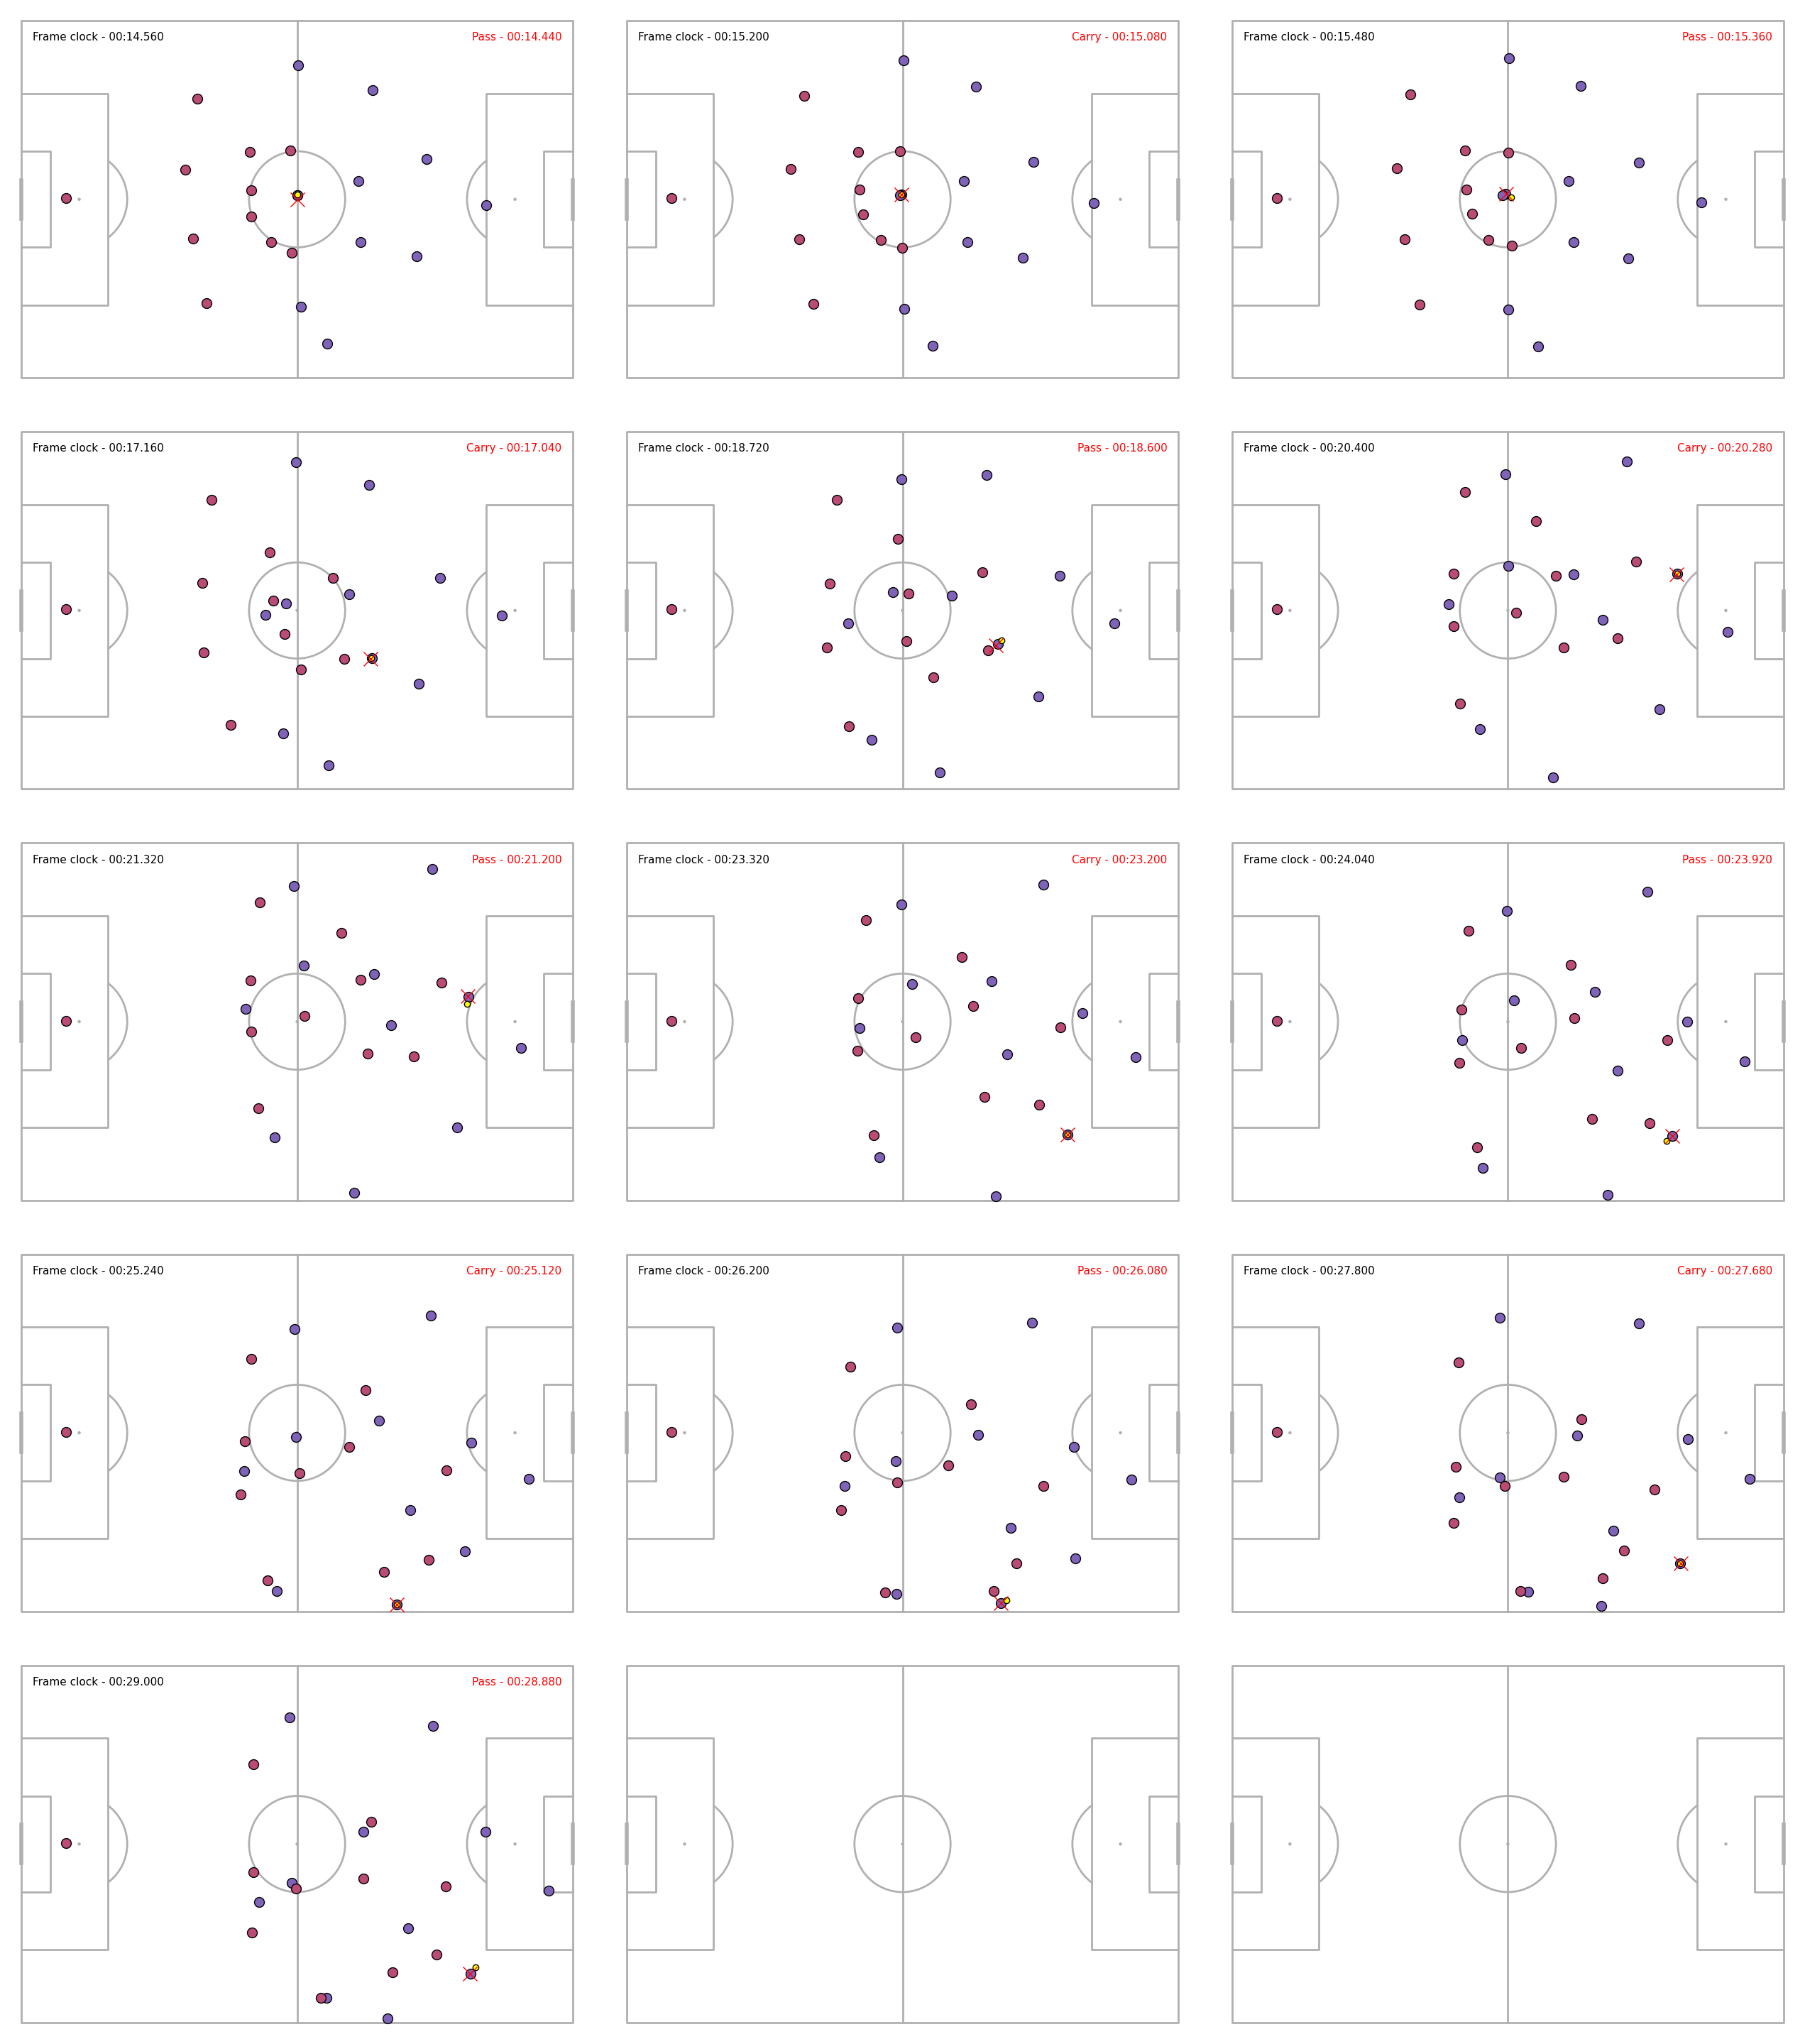

In [7]:
viz.plot_alignment(time_synced_event_dataset)

## Messing up the synchronization 😈

As you can see, this dataset is almost perfectly synchronized. Let's mess up the synchronization such that we can test our algorithm. We'll add some random Gaussian noise to the timestamp and location of each event.

In [8]:
unsynced_event_dataset = utils.unsync(event_dataset, offset = 0, sigma_ts=1, sigma_loc=.01)

Let's try to synchronize again based on the timestamps. It will no longer give a good result...

In [9]:
fail_time_synced_event_dataset = unsynced_event_dataset.sync(tracking_dataset, strategy="timestamps")

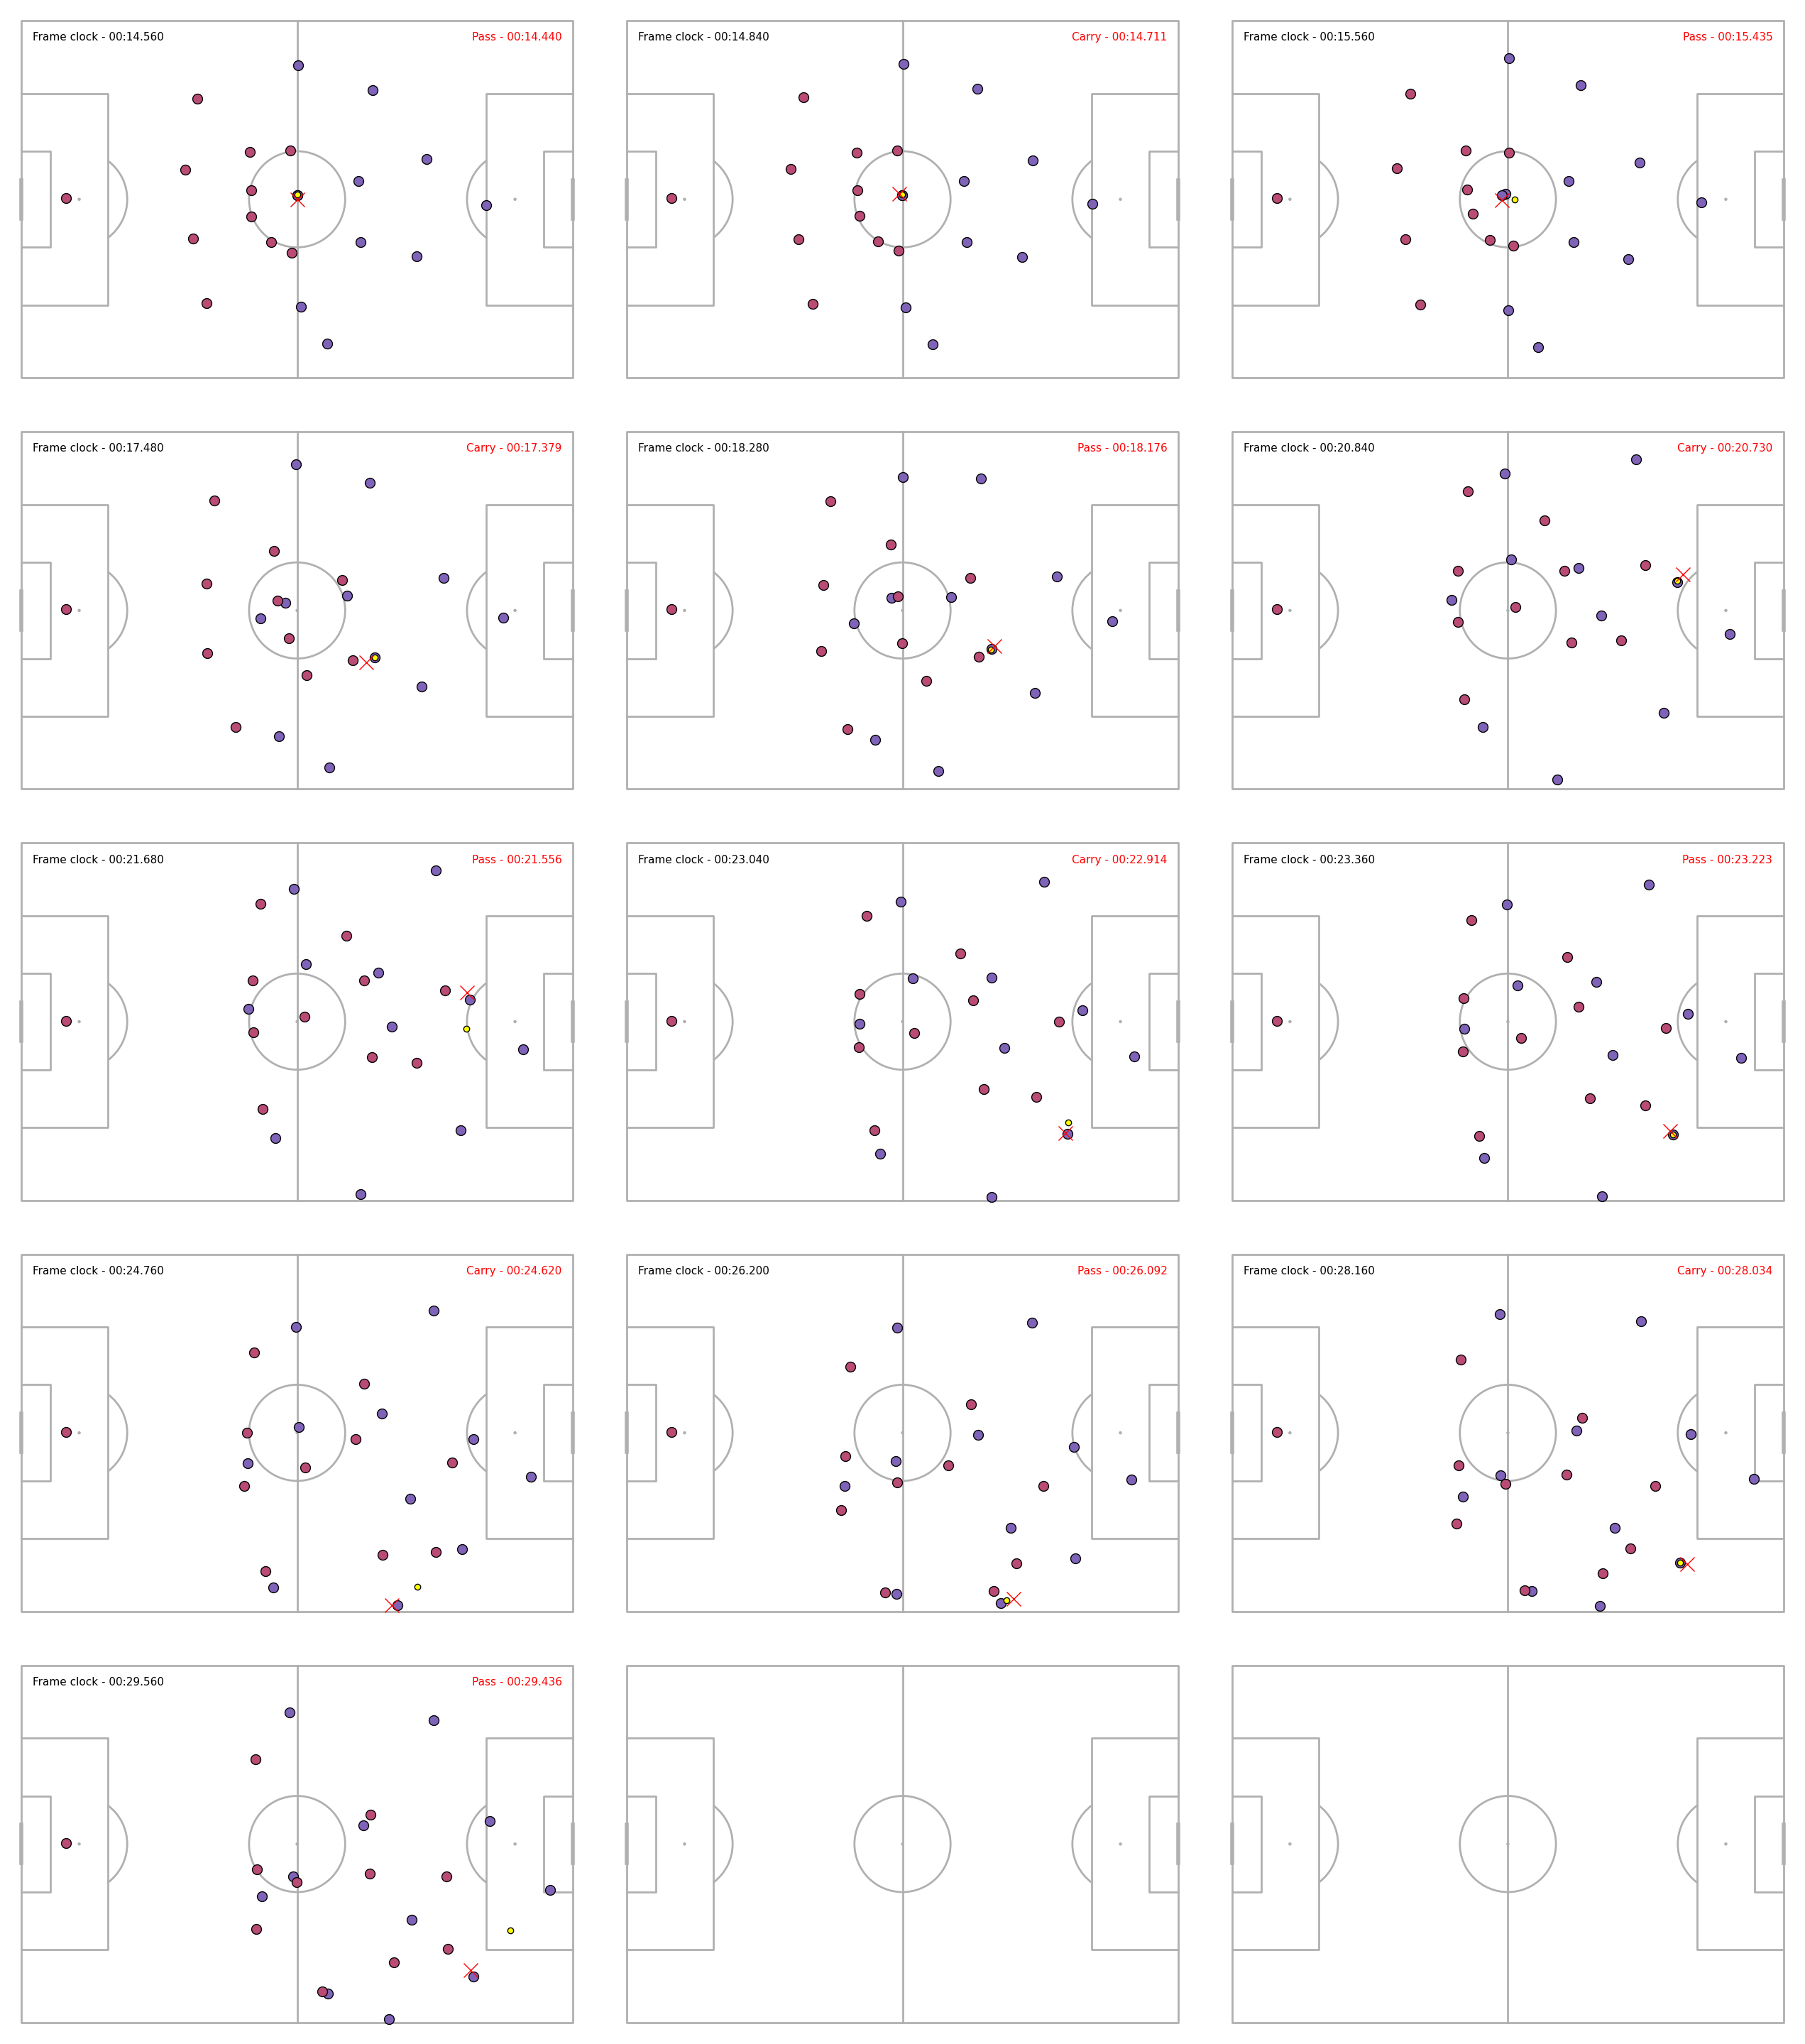

In [10]:
viz.plot_alignment(fail_time_synced_event_dataset)

## Fixing the synchronization

In [11]:
synced_event_dataset = unsynced_event_dataset.sync(tracking_dataset)

In [12]:
anim = viz.animate_alignment(
    synced_event_dataset, 
    tracking_dataset[500:]
)
#HTML(anim.to_jshtml())
HTML(anim.to_html5_video())

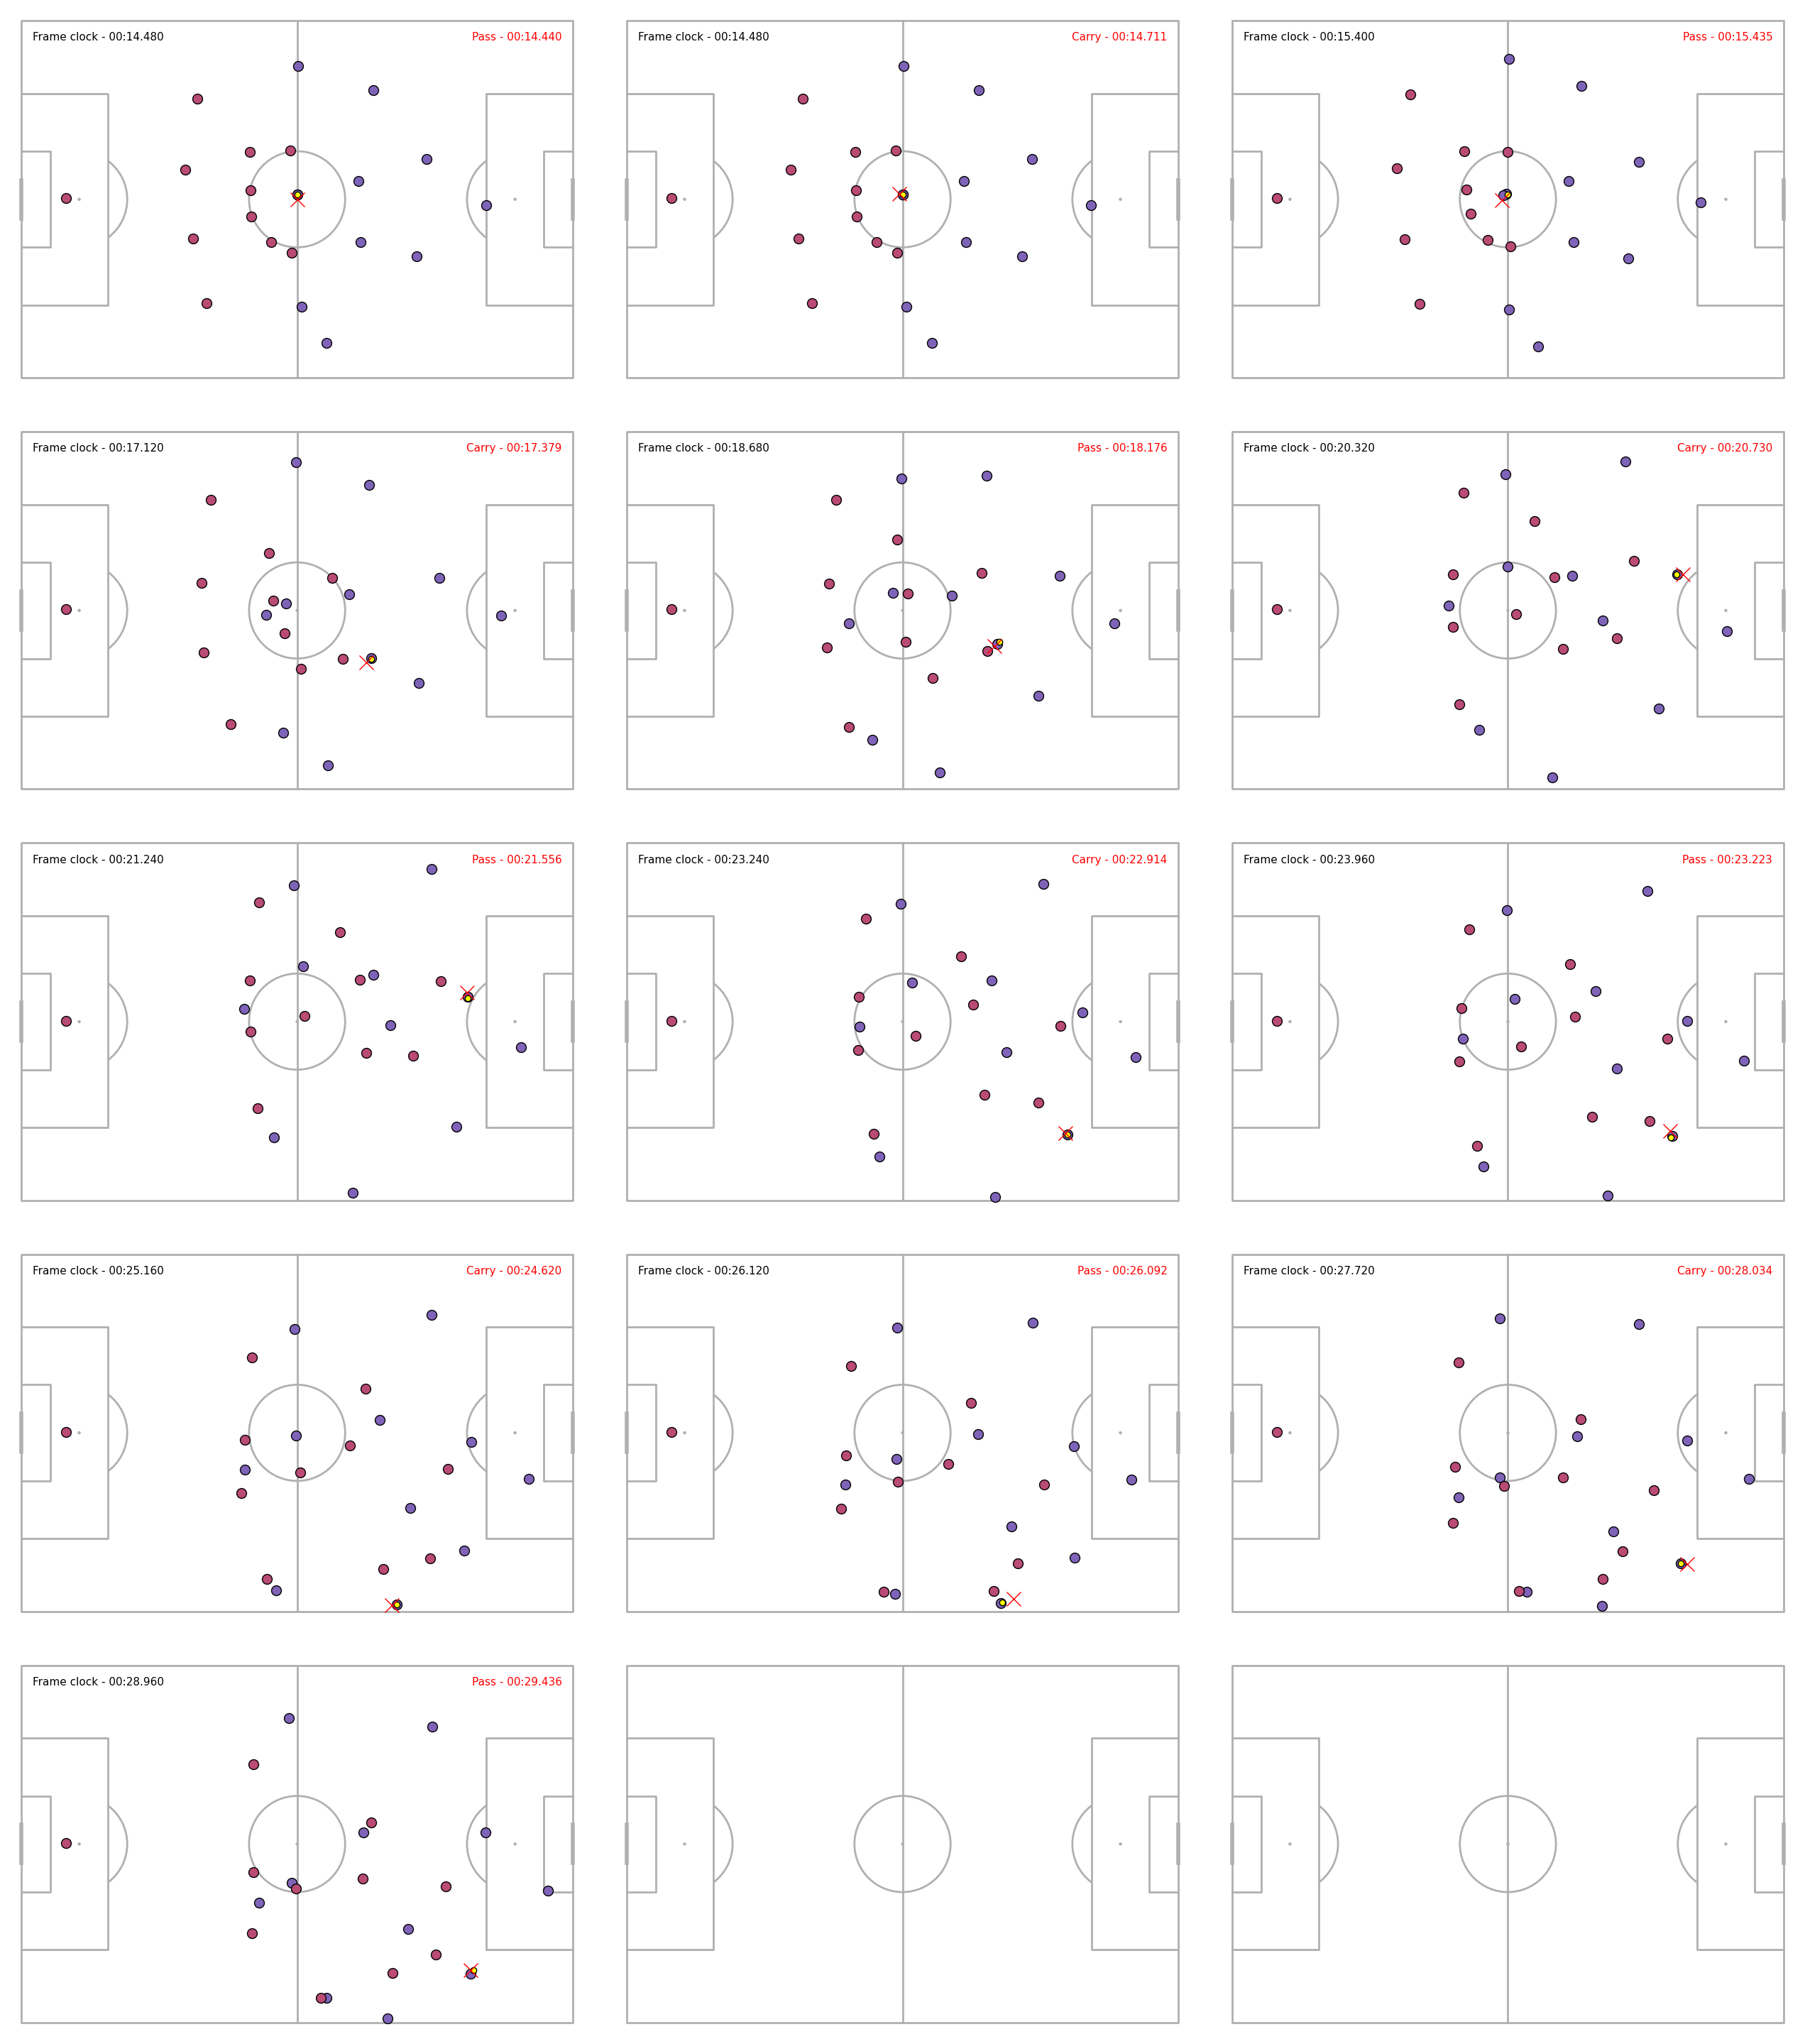

In [13]:
viz.plot_alignment(synced_event_dataset)

## Customizing the synchronisation strategy

A synchronization strategy consists of window function, a scoring function that assigns a score to each event-frame pair, a masking function that masks invalid event-frame pairs, and an alignment algorithm that finds the best alignment between the event and tracking sequences.

### Window function
For each event,  a maximum of `window/2` seconds of tracking data before and after the event timestamp are considered for alignment. Thus, the window function defines the maximum deviation between a timestamp of an event and the timestamp of a tracking frame. The window size can depend on the event. For example, a larger window size can be used for set-pieces than for open-play events.

In [14]:
from kloppy.domain import SetPieceQualifier

def window_fn(event):
    is_set_piece = event.get_qualifier_value(SetPieceQualifier) is not None
    if is_set_piece:
        return 20.0
    return 10.0

### Scoring function
The scoring function assigns a score to each event-frame pair. **Lower values indicate a better match.** As an example, the scoring function defined below assigns a high score to frames in which the acting player (as defined by the event) is close to the ball and where the acceleration of the ball relative to the acting player matches the event's definition (e.g., the acceleration of the ball should increase faster than the acceleration of the acting player on a pass).

In [15]:
from kloppy.domain.services.synchronizers import scoring

In [16]:
score_fn = scoring.combine(
    scoring.mis_possession,
    scoring.mis_player_ball_acceleration
)
score_fn.weights = [1.0, 1.0]

In [17]:
anim = viz.animate_score(
    synced_event_dataset[12], tracking_dataset[550:750], 
    synced_event_dataset.metadata.coordinate_system, 
    score_fn
)
#HTML(anim.to_jshtml())
HTML(anim.to_html5_video())

### Masking function
The masking function defines which frames are not eligible for a match. For example, we can exclude all frames in which the acting player is more than 2 meters away from the ball.

In [18]:
from kloppy.domain.services.synchronizers import masking

In [19]:
from functools import partial

mask_fn = masking.combine(
    partial(masking.mask_ball_possession, max_dist=2.0),
)

In [20]:
anim = viz.animate_score(
    synced_event_dataset[11], tracking_dataset[550:750], 
    synced_event_dataset.metadata.coordinate_system, 
    score_fn,
    mask_fn
)
#HTML(anim.to_jshtml())
HTML(anim.to_html5_video())

### Alignment method
Four alignment methods are implemented:

- `timestamp_alignment`: Each event is matched with the tracking frame based on their timestamps. This method should be used if the  tracking data is already synchronized with the event data.
- `local_alignment`: Defines a window around each event and matches the event with the best-scoring tracking frame within this window. The windows of events can overlap. This method works well for aligning a single category of events that are unique within a time window, such as shots or passes.
- `greedy_alignment`: Defines a window around each event and matches the event with the best-scoring tracking frame within this window. A window can only start after the last matched frame. This is the approach used by ETSY. It is computationally efficient but can lead to suboptimal alignments when similar events occur in close proximity (e.g., a one-two pass).
- `optimal_alignment`: Uses the Needleman-Wunsch dynamic programming algorithm to find the best global alignment between the event and tracking data. This approach is used by sync.soccer. It has the highest computational costs but guarantees the most optimal global alignment.

In [21]:
from kloppy.domain.services.synchronizers import alignment

In [22]:
events = synced_event_dataset[11:12]
frames = tracking_dataset[550:750]
res = alignment.local_alignment(
    events, 
    frames, 
    fps=25, 
    score_fn=score_fn, 
    mask_fn=mask_fn, 
    window_fn=window_fn, 
    offset=frames[0].timestamp
)
for event_idx, frame_idx in res:
    print(f"{events[event_idx]} matches with {frames[frame_idx]}")

<CarryEvent event_id='13' time='P1T00:28' player='Player 3' result='COMPLETE'> matches with <Frame>


### Building a strategy
By combining a scoring function, masking function and alignment method, we can implement all currently documented event-tracking data synchronization methods. Let's illustrate this by implementing a custom strategy.

In [23]:
from kloppy.domain import SynchronizationStrategyBuilder

In [24]:
my_strategy = (
    SynchronizationStrategyBuilder()
    .with_window_fn(window_fn)
    .with_mask_fn(mask_fn)
    .with_score_fn(score_fn)
    .with_alignment_fn(alignment.optimal_alignment)
    .build()
)

Next, you can register this strategy with a name.

In [25]:
my_strategy.register("custom")

### Supported strategies

Kloppy implemenents the following strategies: [ETSY](https://github.com/ML-KULeuven/ETSY), [sync.soccer](https://github.com/huffyhenry/sync.soccer) and Gabriel Anzer and Pascal Bauer's method for synchronizing [shots](https://www.frontiersin.org/articles/10.3389/fspor.2021.624475/full#h4) and [passess](https://link.springer.com/article/10.1007/s10618-021-00810-3#appendices).

*Note: The method for synchronizing passes by Anzer and Bauer requires that the receiver of pass is known. This is not defined in the Metrica event stream data. Therefore, this method does not work optimally for the given dataset.*


In [26]:
strategies = ["default", "ETSY", "sync.soccer", "Anzer and Bauer (passes)", "Anzer and Bauer (shots)", "custom"]

In [27]:
synced_event_datasets = {}
synced_event_datasets["timestamps"] = event_dataset.sync(tracking_dataset, strategy="timestamps", offset=None)
for strategy in strategies:
    synced_event_datasets[strategy] = unsynced_event_dataset.sync(tracking_dataset, strategy=strategy, offset=None)

In [28]:
import pandas as pd

alignments = []
for event_idx, event in enumerate(event_dataset):
    alignment = {
        "event_idx": event_idx,
        "event_type": event.event_name,
        "frame_idx": synced_event_datasets["timestamps"][event_idx].freeze_frame.frame_id 
    }
    for strategy in strategies:
        alignment[f"frame_idx ({strategy})"] =  (
            synced_event_datasets[strategy][event_idx].freeze_frame.frame_id 
            if synced_event_datasets[strategy][event_idx].freeze_frame 
            else None
        )
    alignments.append(alignment)

alignments = pd.DataFrame(alignments)    
for strategy in strategies:
    alignments[f"error ({strategy})"] = (alignments["frame_idx"] - alignments[f"frame_idx ({strategy})"]).abs().astype("Int64")

alignments[["event_idx", "event_type", "frame_idx"] + [f"error ({strategy})" for strategy in strategies]]

event_idx event_type  frame_idx  error (default)  error (ETSY)  \
0           0       pass        361                1            10   
1           1      carry        377               15          <NA>   
2           2       pass        384                1             2   
3           3      carry        426                2          <NA>   
4           4       pass        465                2             2   
5           5      carry        507                1          <NA>   
6           6       pass        530                1            10   
7           7      carry        580                1          <NA>   
8           8       pass        598                1            15   
9           9      carry        628                1          <NA>   
10         10       pass        652                1            26   
11         11      carry        692                1          <NA>   
12         12       pass        722                2             8   

    error (sync.soccer)  error (Anzer and Bauer (passes))  \
0                     0                                25   
1                     3                              <NA>   
2                     2                                 1   
3                     1                              <NA>   
4                     2                                 2   
5                     7                              <NA>   
6                     7                                 1   
7                     0                              <NA>   
8                    18                                 1   
9                     1                              <NA>   
10                    3                                 1   
11                    2                              <NA>   
12                    1                              <NA>   

    error (Anzer and Bauer (shots))  error (custom)  
0                              <NA>               1  
1                              <NA>              15  
2                              <NA>               1  
3                              <NA>               2  
4                              <NA>               1  
5                              <NA>               1  
6                              <NA>               1  
7                              <NA>               1  
8                              <NA>               1  
9                              <NA>               1  
10                             <NA>               1  
11                             <NA>               1  
12                             <NA>               1

🎉 The synchronization of the default method is almost identical to the ground truth time-based synchronization!

## Correcting a constant offset

When the event and tracking data are collected by different providers, there will often be a constant bias between the timestamps of both data sources because they each use their own clock. This bias can be automatically rectified trough an algorithm that attempts to find the kick-off frames. Alternatively, it can be manually adjusted by hard-coding the offset for each time period.

In [29]:
# add an offset of -5 seconds (i.e., the kick-off event will be 5 seconds earlier)
biased_event_dataset = utils.unsync(event_dataset, offset = -5, sigma_ts=0, sigma_loc=0)

# automatically attempt to correct the offset
time_synced_biased_event_dataset = biased_event_dataset.sync(tracking_dataset, strategy="timestamps", offset='auto')
# or provide the offset
# time_synced_biased_event_dataset = biased_event_dataset.sync(tracking_dataset, strategy="timestamps", offset=[-5, -5])

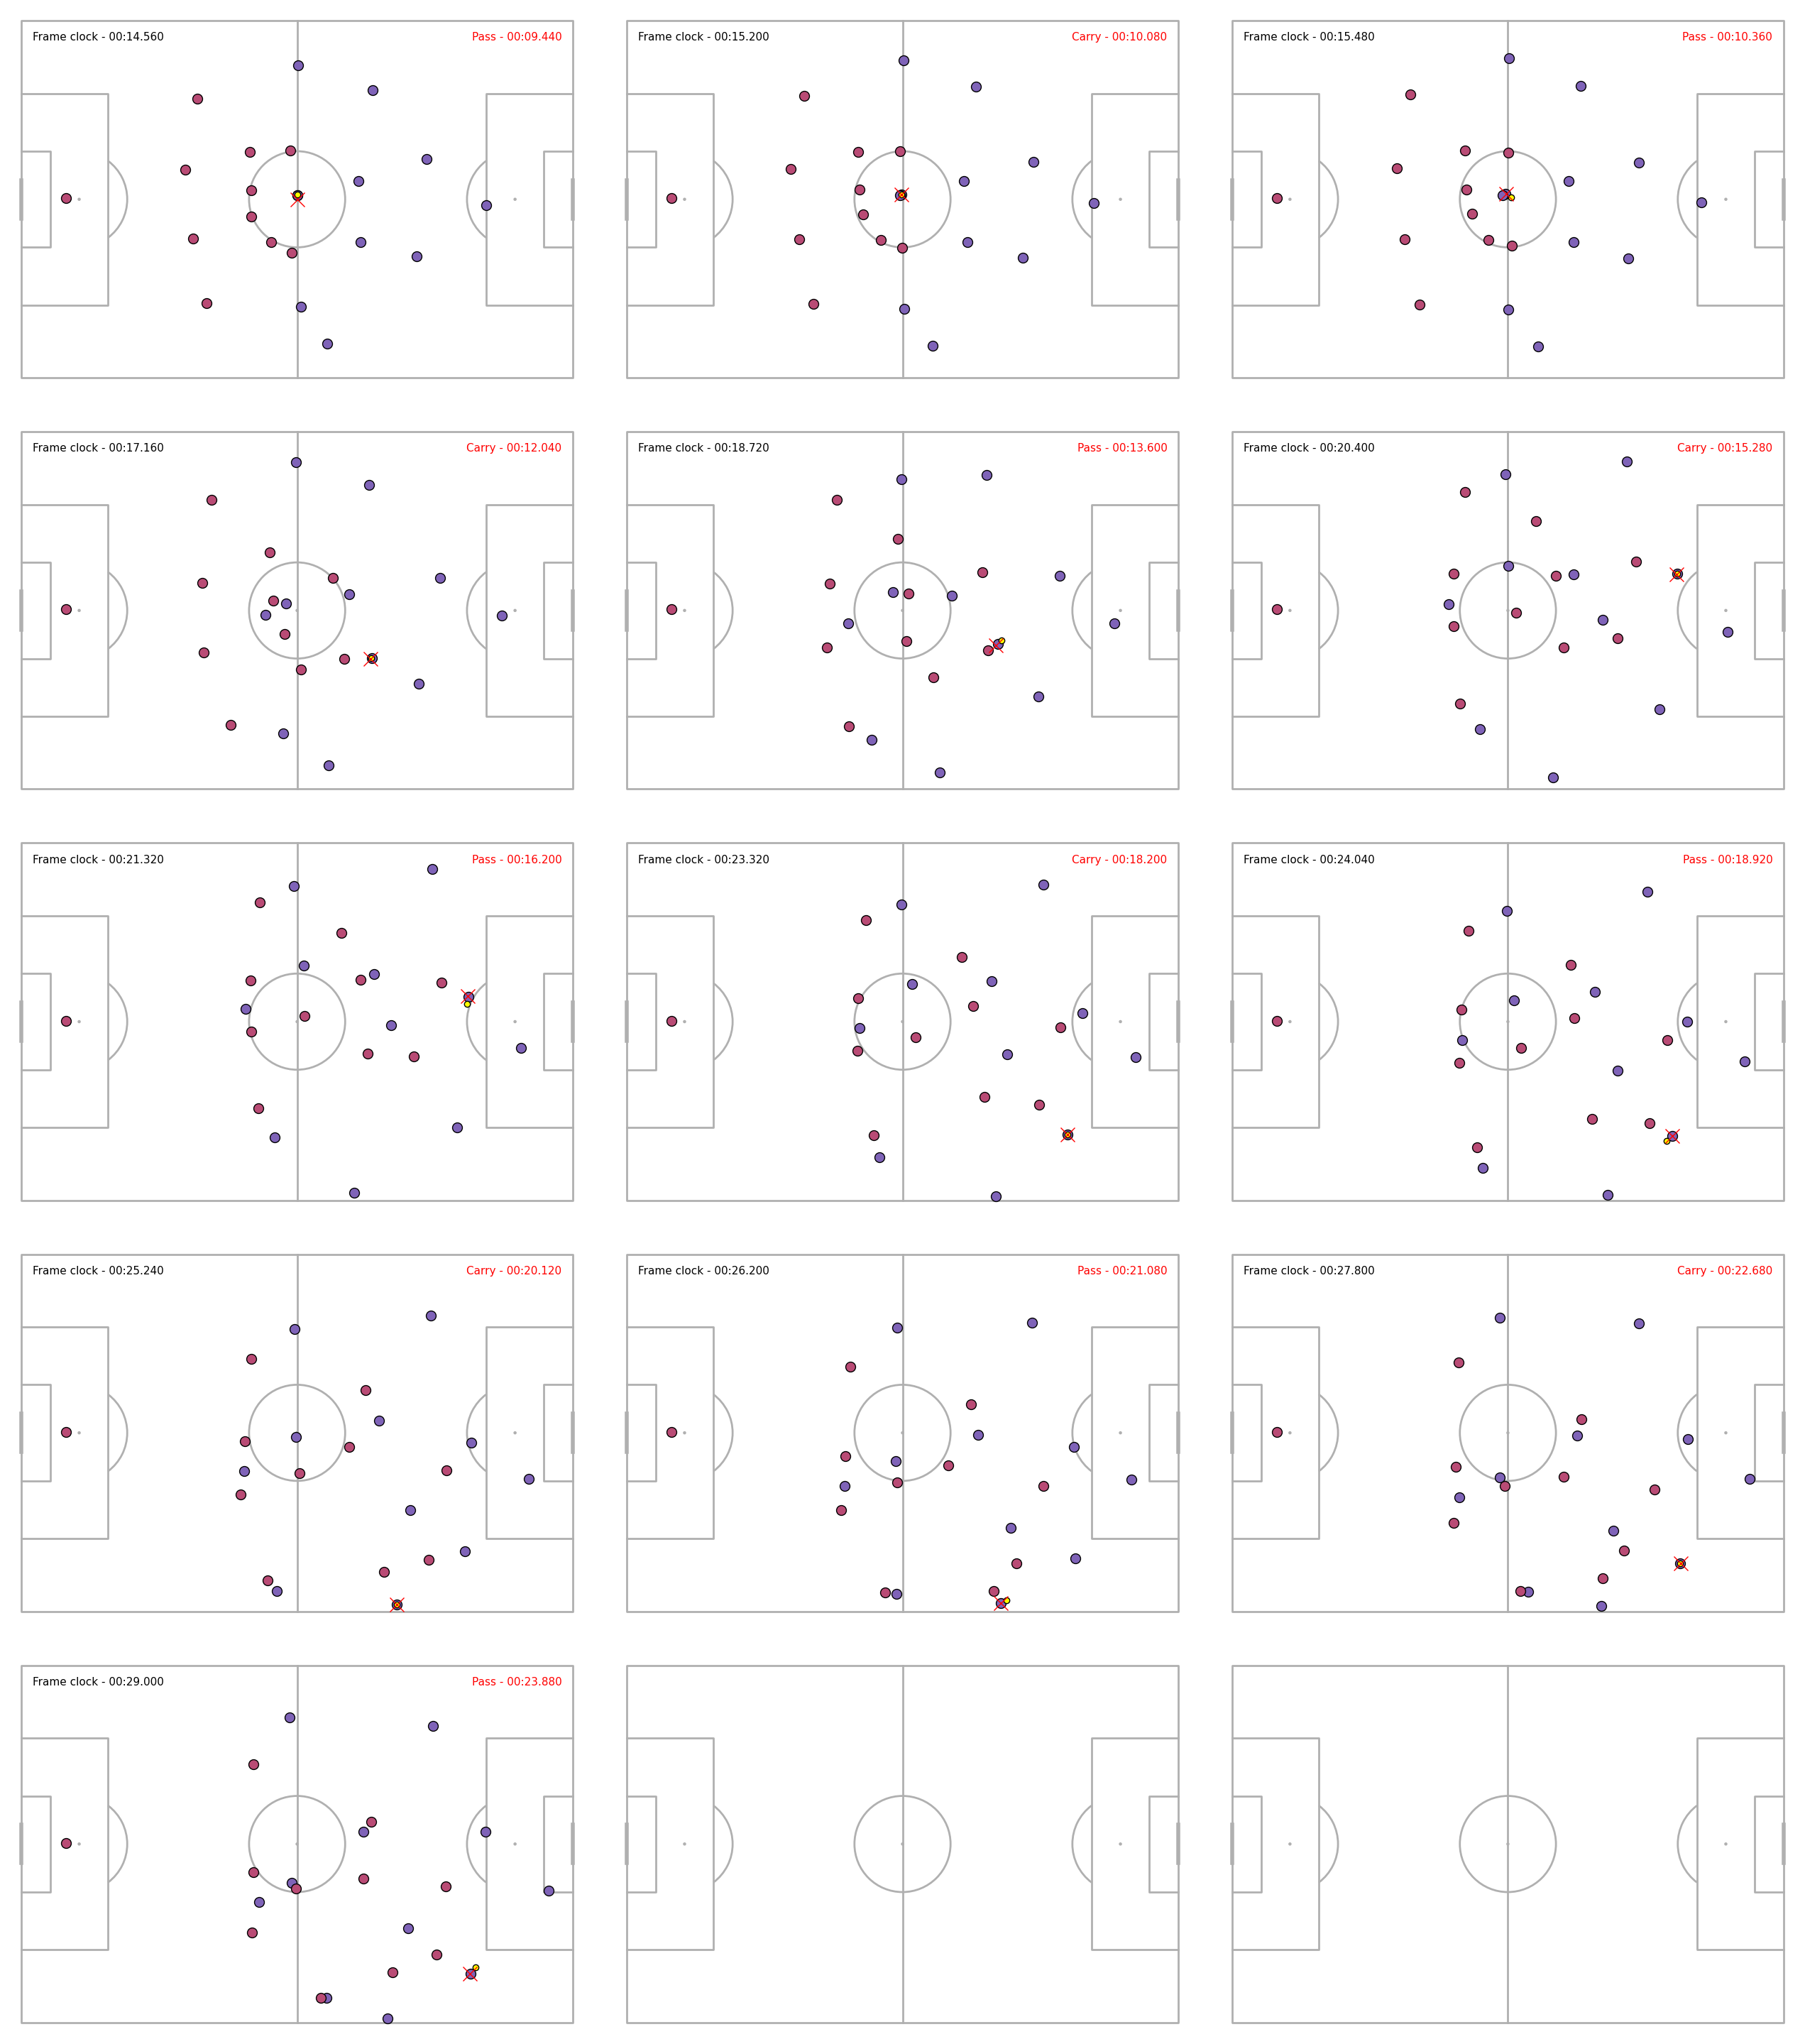

In [30]:
viz.plot_alignment(time_synced_biased_event_dataset)

# Full dataset benchmarks

In [31]:
from kloppy import metrica

# Load the raw data, we'll only load the first 30 seconds of the game
API_URL = "https://raw.githubusercontent.com/metrica-sports/sample-data/master/data"
tracking_dataset = metrica.load_tracking_epts(
    meta_data=f"{API_URL}/Sample_Game_3/Sample_Game_3_metadata.xml",
    raw_data=f"{API_URL}/Sample_Game_3/Sample_Game_3_tracking.txt",
    coordinates="metrica"
)
event_dataset = metrica.load_event(
    meta_data=f"{API_URL}/Sample_Game_3/Sample_Game_3_metadata.xml",
    event_data=f"{API_URL}/Sample_Game_3/Sample_Game_3_events.json",
    coordinates="metrica"
)

In [32]:
unsynced_event_dataset = utils.unsync(event_dataset, offset = 0, sigma_ts=1, sigma_loc=.01)
synced_event_datasets = {}

In [33]:
%%time
synced_event_datasets["timestamps"] = event_dataset.sync(
    tracking_dataset, strategy="timestamps", offset=None
)

CPU times: user 25.4 s, sys: 474 ms, total: 25.8 s
Wall time: 25.8 s


In [34]:
%%time
synced_event_datasets["default"] = unsynced_event_dataset.sync(
    tracking_dataset, strategy="default", offset=None, show_progress=True, 
    scale_mis_clock=1.5,
    scale_mis_ball_state=1.0,
    scale_mis_ball_location=1.0,
    scale_mis_possession=1.0,
    scale_mis_player_ball_acceleration=0.2,
)

Synchronizing period 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1614/1614 [00:04<00:00, 346.88it/s]


CPU times: user 37.3 s, sys: 1.91 s, total: 39.2 s
Wall time: 39.2 s


In [35]:
%%time
synced_event_datasets["ETSY"] = unsynced_event_dataset.sync(
    tracking_dataset, strategy="ETSY", offset=None, show_progress=True
)

Synchronizing period 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1614/1614 [00:00<00:00, 1955.13it/s]


CPU times: user 26.9 s, sys: 491 ms, total: 27.4 s
Wall time: 27.4 s


In [36]:
%%time
synced_event_datasets["sync.soccer"] = unsynced_event_dataset.sync(
    tracking_dataset, strategy="sync.soccer", offset=None, show_progress=True
)

Synchronizing period 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1614/1614 [00:04<00:00, 377.36it/s]


CPU times: user 36.4 s, sys: 1.86 s, total: 38.2 s
Wall time: 38.2 s


In [37]:
%%time
synced_event_datasets["Anzer and Bauer (shots)"] = unsynced_event_dataset.sync(
    tracking_dataset, strategy="Anzer and Bauer (shots)", offset=None, show_progress=True
)

Synchronizing period 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 594.52it/s]

CPU times: user 28.7 s, sys: 511 ms, total: 29.2 s
Wall time: 29.2 s


In [38]:
%%time
synced_event_datasets["Anzer and Bauer (passes)"] = unsynced_event_dataset.sync(
    tracking_dataset, strategy="Anzer and Bauer (passes)", offset=None, show_progress=True
)

Synchronizing period 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 737/737 [00:03<00:00, 186.82it/s]


CPU times: user 33.8 s, sys: 509 ms, total: 34.3 s
Wall time: 34.3 s


In [39]:
%%time
synced_event_datasets["custom"] = unsynced_event_dataset.sync(
    tracking_dataset, strategy="custom", offset=None, show_progress=True
)

Synchronizing period 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1614/1614 [00:03<00:00, 428.90it/s]


CPU times: user 36.3 s, sys: 1.92 s, total: 38.2 s
Wall time: 38.1 s


In [40]:
import pandas as pd

alignments = []
for event_idx, event in enumerate(event_dataset):
    alignment = {
        "event_idx": event_idx,
        "event_type": event.event_name,
        "frame_idx": (
            synced_event_datasets["timestamps"][event_idx].freeze_frame.frame_id
            if synced_event_datasets["timestamps"][event_idx].freeze_frame 
            else None
        )
    }
    for strategy in strategies:
        alignment[f"frame_idx ({strategy})"] =  (
            synced_event_datasets[strategy][event_idx].freeze_frame.frame_id 
            if synced_event_datasets[strategy][event_idx].freeze_frame 
            else None
        )
    alignments.append(alignment)

alignments = pd.DataFrame(alignments)    
for strategy in strategies:
    alignments[f"error ({strategy})"] = (alignments["frame_idx"] - alignments[f"frame_idx ({strategy})"]).abs().astype("Int64")

alignments[["event_idx", "event_type", "frame_idx"] + [f"error ({strategy})" for strategy in strategies]]

event_idx event_type  frame_idx  error (default)  error (ETSY)  \
0             0       pass      361.0                1            10   
1             1      carry      377.0               15          <NA>   
2             2       pass      384.0                1             2   
3             3      carry      426.0                2          <NA>   
4             4       pass      465.0                2             2   
...         ...        ...        ...              ...           ...   
3589       3589       pass   143406.0                2             1   
3590       3590       pass   143469.0                0             0   
3591       3591      carry   143469.0                0          <NA>   
3592       3592      carry   143532.0                2          <NA>   
3593       3593       pass   143553.0                9             6   

      error (sync.soccer)  error (Anzer and Bauer (passes))  \
0                       0                                25   
1                       3                              <NA>   
2                       2                                 1   
3                       1                              <NA>   
4                       2                                 2   
...                   ...                               ...   
3589                    1                                 2   
3590                    0                                 1   
3591                    0                              <NA>   
3592                    0                              <NA>   
3593                   13                                22   

      error (Anzer and Bauer (shots))  error (custom)  
0                                <NA>               1  
1                                <NA>              15  
2                                <NA>               1  
3                                <NA>               2  
4                                <NA>               1  
...                               ...             ...  
3589                             <NA>               1  
3590                             <NA>               0  
3591                             <NA>               0  
3592                             <NA>               2  
3593                             <NA>               4  

[3594 rows x 9 columns]

In [41]:
for strategy in strategies:
    print("{}: {:.2f} ± {:.2f} | {:.2%} unaligned".format(
        strategy,
        alignments[f"error ({strategy})"].mean(),
        alignments[f"error ({strategy})"].std(),
        (alignments[f"error ({strategy})"].isna().sum() -  alignments["frame_idx"].isna().sum()) / (~alignments["frame_idx"].isna()).sum()
    ))

default: 1.71 ± 3.34 | 6.01% unaligned
ETSY: 4.88 ± 11.30 | 47.46% unaligned
sync.soccer: 3.82 ± 8.52 | 0.00% unaligned
Anzer and Bauer (passes): 3.83 ± 10.09 | 57.83% unaligned
Anzer and Bauer (shots): 3.26 ± 6.74 | 99.41% unaligned
custom: 2.71 ± 10.97 | 5.64% unaligned


In [42]:
alignments.groupby("event_type")["error (default)"].mean()

event_type
CARD                  <NA>
CHALLENGE             <NA>
ball_out              <NA>
carry             1.729008
foul_committed         0.2
pass              1.605776
recovery          2.258993
shot              1.526316
Name: error (default), dtype: Float64

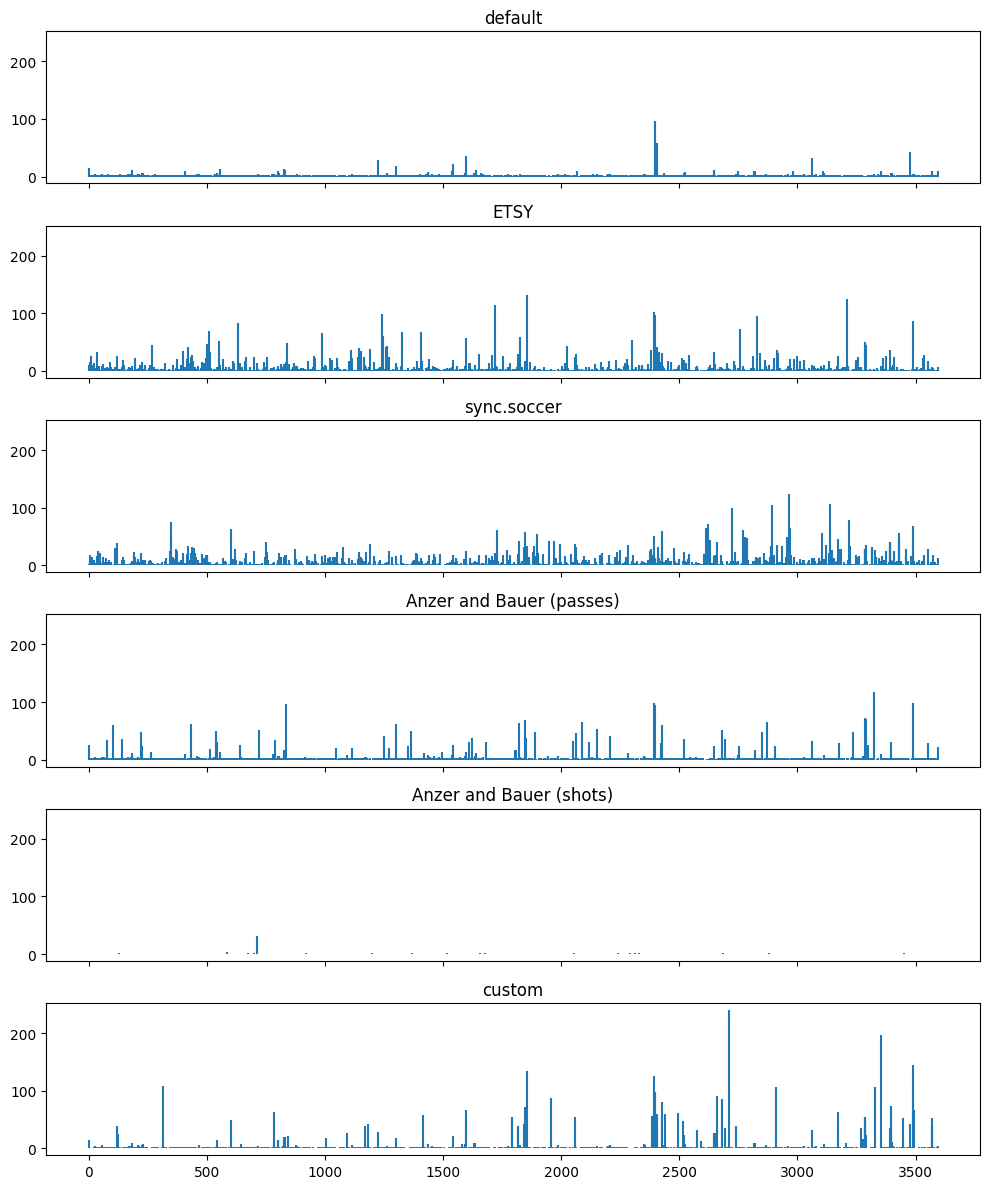

In [43]:
fix, axes = plt.subplots(len(strategies), figsize=(10,len(strategies)*2), sharex=True, sharey=True)
for ax, strategy in zip(axes.flat, strategies):
    ax.vlines(alignments["event_idx"], [0]*len(alignments), alignments[f"error ({strategy})"].fillna(0))
    ax.set_title(strategy)
plt.tight_layout()
plt.show()

In [44]:
# which events have an error > 1 second?
alignments[alignments["error (default)"] > 25]

event_idx event_type  frame_idx  frame_idx (default)  frame_idx (ETSY)  \
1224       1224   recovery    48738.0              48709.0           48740.0   
1598       1598      carry    62284.0              62320.0               NaN   
2396       2396   recovery    95963.0              96060.0           96060.0   
2398       2398      carry    95963.0              96060.0               NaN   
2406       2406      carry    96014.0              96073.0               NaN   
2407       2407       pass    96031.0              96073.0           96072.0   
3062       3062       pass   121566.0             121598.0          121577.0   
3478       3478      carry   139287.0             139244.0               NaN   

      frame_idx (sync.soccer)  frame_idx (Anzer and Bauer (passes))  \
1224                  48740.0                                   NaN   
1598                  62309.0                                   NaN   
2396                  95975.0                                   NaN   
2398                  95975.0                                   NaN   
2406                  96018.0                                   NaN   
2407                  96032.0                               96033.0   
3062                 121577.0                              121598.0   
3478                 139287.0                                   NaN   

      frame_idx (Anzer and Bauer (shots))  frame_idx (custom)  \
1224                                  NaN             48709.0   
1598                                  NaN             62325.0   
2396                                  NaN             96060.0   
2398                                  NaN             96060.0   
2406                                  NaN             96073.0   
2407                                  NaN             96073.0   
3062                                  NaN            121598.0   
3478                                  NaN            139244.0   

      error (default)  error (ETSY)  error (sync.soccer)  \
1224               29             2                    2   
1598               36          <NA>                   25   
2396               97            97                   12   
2398               97          <NA>                   12   
2406               59          <NA>                    4   
2407               42            41                    1   
3062               32            11                   11   
3478               43          <NA>                    0   

      error (Anzer and Bauer (passes))  error (Anzer and Bauer (shots))  \
1224                              <NA>                             <NA>   
1598                              <NA>                             <NA>   
2396                              <NA>                             <NA>   
2398                              <NA>                             <NA>   
2406                              <NA>                             <NA>   
2407                                 2                             <NA>   
3062                                32                             <NA>   
3478                              <NA>                             <NA>   

      error (custom)  
1224              29  
1598              41  
2396              97  
2398              97  
2406              59  
2407              42  
3062              32  
3478              43

In [45]:
from kloppy.domain import create_synchronization_strategy

event_idx = 2398
frame_idx = alignments.at[event_idx, "frame_idx"].astype(int)
strategy = create_synchronization_strategy("default")

display(alignments.loc[event_idx-1:event_idx+1])

anim = viz.animate_score(
    unsynced_event_dataset[event_idx], tracking_dataset[(frame_idx-50):(frame_idx+50)], 
    synced_event_dataset.metadata.coordinate_system, 
    strategy.score_fn,
    strategy.mask_fn
)
HTML(anim.to_jshtml())

event_idx event_type  frame_idx  frame_idx (default)  frame_idx (ETSY)  \
2397       2397       pass    95963.0                  NaN               NaN   
2398       2398      carry    95963.0              96060.0               NaN   
2399       2399      carry    95982.0                  NaN               NaN   

      frame_idx (sync.soccer)  frame_idx (Anzer and Bauer (passes))  \
2397                  95975.0                               95868.0   
2398                  95975.0                                   NaN   
2399                  95983.0                                   NaN   

      frame_idx (Anzer and Bauer (shots))  frame_idx (custom)  \
2397                                  NaN                 NaN   
2398                                  NaN             96060.0   
2399                                  NaN                 NaN   

      error (default)  error (ETSY)  error (sync.soccer)  \
2397             <NA>          <NA>                   12   
2398               97          <NA>                   12   
2399             <NA>          <NA>                    1   

      error (Anzer and Bauer (passes))  error (Anzer and Bauer (shots))  \
2397                                95                             <NA>   
2398                              <NA>                             <NA>   
2399                              <NA>                             <NA>   

      error (custom)  
2397            <NA>  
2398              97  
2399            <NA>